In [ ]:
import pandas as pd
import scanpy as sc

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

import loompy as lp
import numpy as np
import os
#!pip install distributed==2023.12.1

In [ ]:
# Folder structure
RESOURCES_FOLDERNAME = '/data/project/AI4Omic/MASLD/results/scRNA/pyscenic/reference'
RESULTS_FOLDERNAME = '/data/project/AI4Omic/MASLD/results/scRNA/pyscenic'

# figure settings
sc.settings.figdir = RESULTS_FOLDERNAME
sc.set_figure_params(dpi=300, fontsize=10, dpi_save=300, format='pdf')

In [ ]:
# step1 Network inference based on GRNBoost2 from CLI
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, 'scRNA.loom')
HUMAN_TFS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'hs_hgnc_tfs.txt')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, 'adj.tsv')
#ADJACENCIES_FNAME = '/data/project/AI4Omic/NAFLD/results/scRNA/pyscenic/adj.tsv'

In [ ]:
adjacencies = pd.read_csv(ADJACENCIES_FNAME, index_col=False, sep='\t')
adjacencies.loc[adjacencies['target'] == 'SPP1'].sort_values('importance', ascending=False).head(50)

TF target  importance
2557        SOX9   SPP1    7.436688
6399        ELF3   SPP1    4.745359
31847      FOXQ1   SPP1    2.534679
58995       KLF5   SPP1    1.914773
68530      HNF1B   SPP1    1.775134
72468        EHF   SPP1    1.722334
92352       SOX4   SPP1    1.506672
168196      CD59   SPP1    1.056559
292554      MITF   SPP1    0.724722
318714      ATF3   SPP1    0.680760
403770      ETV4   SPP1    0.573382
433655   ONECUT1   SPP1    0.544403
592508     HMGN3   SPP1    0.425952
605928     HNF4G   SPP1    0.417682
627699     GLIS3   SPP1    0.404478
627747   BHLHE41   SPP1    0.404448
630663      EGR1   SPP1    0.402718
632508     GRHL2   SPP1    0.401626
790586      HES1   SPP1    0.316898
827826     NR1H3   SPP1    0.299304
867569     HCLS1   SPP1    0.281375
878228     FOXA2   SPP1    0.276592
925361     GATA6   SPP1    0.256404
974745     NR2F2   SPP1    0.236536
1029241    FOXA1   SPP1    0.216006
1047762  ONECUT2   SPP1    0.209379
1081861  ZKSCAN1   SPP1    0.197735
1108911    PPARG   SPP1    0.188863
1228666     PDX1   SPP1    0.153583
1340759     HHEX   SPP1    0.125644
1348203      JUN   SPP1    0.123965
1389934    PROX1   SPP1    0.114962
1417320     MYRF   SPP1    0.109328
1486049     MAFB   SPP1    0.096013
1500952     CANX   SPP1    0.093288
1517602    TGIF1   SPP1    0.090324
1540497     A1CF   SPP1    0.086362
1581914     NFIB   SPP1    0.079404
1633867    YWHAE   SPP1    0.071104
1646294   ANXA11   SPP1    0.069196
1651107    NR4A2   SPP1    0.068469
1715796   AKR1A1   SPP1    0.058941
1726143     SOD1   SPP1    0.057449
1783286    HSPA5   SPP1    0.049420
1783534      PKM   SPP1    0.049384
1825612    PSMC2   SPP1    0.043626
1884163      RAN   SPP1    0.035959
1899817    MEF2C   SPP1    0.033952
1936533   SFT2D1   SPP1    0.029363
1943416      PLG   SPP1    0.028515

In [ ]:
adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/CellphoneDB/adata_major_29samples.h5ad')
adata.X = adata.layers['counts'].copy()

# Downsampling 5% of cells for each cell type
frac = 0.05
selected_indices = []
for cell_type_lvl2, indices in adata.obs.groupby('cell_type_lvl2').indices.items():
    num_samples = int(len(indices) * frac)
    sampled_indices = np.random.choice(indices, num_samples, replace=False)
    selected_indices.extend(sampled_indices)

adata = adata[selected_indices]

In [ ]:
# Load the adj file
adjacencies = pd.read_csv(ADJACENCIES_FNAME, index_col=False, sep='\t')

# obtain the genes that are both in the adata and the adjacencies
genes_intersected = np.intersect1d(list(adjacencies.target.unique()) + list(adjacencies.TF.unique()), adata.var_names)

# subset both the adata and the adjacencies
adata = adata[:, genes_intersected].copy()
adjacencies = adjacencies.loc[adjacencies.target.isin(genes_intersected) & adjacencies.TF.isin(genes_intersected)]
adjacencies.to_csv(ADJACENCIES_FNAME, sep='\t', index=False)

In [ ]:
# Minor Revision
adata_ref = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/CellphoneDB/adata_major_29samples.h5ad')
adata = sc.read_h5ad(os.path.join(RESULTS_FOLDERNAME, 'post-pyscenic.h5ad'))
adata.obs_names = adata.obs_names.str.replace('MASLD', 'MASL')
adata.obs.disease_status = adata.obs.disease_status.cat.rename_categories({'MASLD': 'MASL'})
adata.obs.disease_status = adata.obs.disease_status.cat.reorder_categories(['CTRL', 'MASL', 'MASH'], ordered=True)
adata = adata[adata.obs_names.isin(adata_ref.obs_names)].copy() # 133,321 cells
adata.obs['cell_type_lvl2'] = adata.obs['cell_type_lvl2'].cat.rename_categories({'Teff': "Teff_CD8", 'Tnaive': 'Tnaive_CD4/CD8'})

In [ ]:
# create loom file
row_attrs = {"Gene": np.array(adata.var_names),}
col_attrs = {
    "CellID": np.array(adata.obs_names),
    'nGene': np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(),
    'nUMI': np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
    'sample': np.array(adata.obs['sample']),
    'disease_status': np.array(adata.obs['disease_status'])
}
lp.create(LOOM_FNAME, adata.X.transpose(), row_attrs, col_attrs)

In [53]:
!python -m pyscenic.cli.arboreto_with_multiprocessing {LOOM_FNAME} {HUMAN_TFS_FNAME} --method grnboost2 --output {ADJACENCIES_FNAME} --num_workers 80 --seed 777

Loaded expression matrix of 111360 cells and 15000 genes in 18.205092668533325 seconds...
Loaded 1839 TFs...
starting grnboost2 using 80 processes...
100%|██████████████████████████████████| 15000/15000 [95:52:42<00:00, 23.01s/it]
Done in 345191.23827958107 seconds.


In [37]:
!chmod 777 /home/bailab/miniconda3/envs/pyscenic/lib/python3.10/site-packages/pyscenic/cli/arboreto_with_multiprocessing.py

In [ ]:
!pyscenic grn {LOOM_FNAME} {HUMAN_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 80

In [ ]:
sc.pl.umap(adata, color=['MITF'], cmap='magma', save='MITF.pdf', vmax=18, layer='counts') # 'LHX2', 'TNFRSF11A', 'CDC27P3'

In [5]:
#step 2-3 : Regulon prediction aka cisTarget from CLI
#ranking databases
#import glob
#f_db_glob = os.path.join(RESOURCES_FOLDERNAME, '*feather')
#f_db_names = ' '.join(glob.glob(f_db_glob))
f_db_names = f'{RESOURCES_FOLDERNAME}/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather'

#motif databases
f_motif_path = os.path.join(RESOURCES_FOLDERNAME, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
REG_FNAME = os.path.join(RESULTS_FOLDERNAME, 'reg.csv')

In [ ]:
!pip3 --python `which python` install dask==2024.10.0

In [29]:
!pyscenic ctx {ADJACENCIES_FNAME} {f_db_names} --annotations_fname {f_motif_path} --expression_mtx_fname {LOOM_FNAME} --output {REG_FNAME} --mask_dropouts --num_workers 50

/home/bailab/.local/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/bailab/.local/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/bailab/.local/lib/python3.10/site-pa

In [6]:
#step4: Cellular enrichment from CLI
f_pyscenic_output = os.path.join(RESULTS_FOLDERNAME, 'pyscenic_output.csv')

In [7]:
!pyscenic aucell {LOOM_FNAME} {REG_FNAME} --output {f_pyscenic_output} --num_workers 50

/home/bailab/.local/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/bailab/.local/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/bailab/.local/lib/python3.10/site-pa

In [8]:
# collect SCENIC AUCell output
#lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)
#auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index = lf.ca.CellID)
#lf.close()

# Collect SCENIC AUCell output
auc_mtx = pd.read_csv(f_pyscenic_output, index_col=0)

In [11]:
df_motifs = load_motifs(REG_FNAME)
regulons = df2regulons(df_motifs)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [12]:
regulons

[Regulon(name='ATF3(+)', gene2weight=frozendict.frozendict({'DUSP1': 1.396793572831612, 'BAX': 0.5217651766721928, 'APEX1': 0.5414427640574605, 'SIRT1': 1.2433777438020832, 'ARMT1': 0.4412013818119856, 'VPS26A': 1.702253137949596, 'SGTA': 1.2368830101000352, 'STX4': 1.3294127701958536, 'ATG3': 0.5819400842360789, 'KHDRBS1': 0.4059672724317538, 'NR4A3': 3.084878227551711, 'HNRNPH2': 0.6273936252703591, 'GNPTG': 0.7784255432323198, 'CTBP2': 0.6328805314714884, 'MTDH': 0.4330363797595917, 'COMMD9': 1.006666734981966, 'SLC25A33': 2.012435749802622, 'VPS11': 0.4622949343455014, 'ATXN3': 3.03055735848234, 'EIF3A': 1.1821438498237329, 'TESK2': 0.9920186452292008, 'CAHM': 0.4220065330707364, 'PDP1': 2.214186655791392, 'NTMT1': 0.4759152242230323, 'C1orf43': 0.5904380910059733, 'SLC25A36': 0.4268328994634716, 'TSC1': 0.4323782419560621, 'AP1S2': 0.5805281585832057, 'TOM1': 2.604280859188521, 'C16orf72': 0.6818943910869681, 'ATF4': 1.312648382779232, 'STX5': 0.6475812137635034, 'COMMD3': 0.76662

In [ ]:
# Add all metadata derived from SCENIC to the scanpy.AnnData object
add_scenic_metadata(adata, auc_mtx, regulons)

In [58]:
adata.write(os.path.join(RESULTS_FOLDERNAME, 'post-pyscenic.h5ad'))

In [57]:
adata = sc.read_h5ad(os.path.join(RESULTS_FOLDERNAME, 'post-pyscenic.h5ad'))

In [ ]:
# adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
target_genes = ['FABP4', 'LPL', 'FABP5', 'DHRS9', 'MGLL', 'PLA2G7']
sc.set_figure_params(dpi=300, fontsize=10, dpi_save=300, format='pdf')
sc.pl.umap(adata, color=target_genes, ncols=2, save='MITF_targets', cmap='RdPu', hspace=0.2, wspace=0.15)

In [ ]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = adata.obs

Regulon specificity scores (RSS) across cell types

In [11]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
#!pip install adjustText
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize
import matplotlib as mpl

In [ ]:
#Calculate RSS
#rss_celltype = regulon_specificity_scores(auc_mtx.loc[adata[adata.obs['disease_status']=='MASH'].obs_names, :], adata[adata.obs['disease_status']=='MASH'].obs.cell_type_lvl2)
rss_celltype = regulon_specificity_scores(auc_mtx, adata.obs.cell_type_lvl2)
#rss_celltype.to_csv(os.path.join(RESULTS_FOLDERNAME, 'rss_celltype.csv')) 

RSS panel plot with all cell types


In [45]:
cats = sorted(list(set(adata.obs.cell_type_lvl2)))
cats.remove('LAM')

fig = plt.figure(figsize=(20, 20))
for c,num in zip(cats,range(1,len(cats)+1)):
    x = rss_celltype.T[c]
    ax = fig.add_subplot(5,5,num)
    plot_rss(rss_celltype,c,top_n=5,max_n=None,ax=ax)
    ax.set_ylim(x.min()-(x.max()-x.min())*0.05,x.max()+(x.max()-x.min())*0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='lightgrey'), precision=0.001)
fig.text(0.5,0.0,'Regulon', ha='center',va='center', size='x-large')
fig.text(0.00,0.5,'Regulon specificity score (RSS)', ha='center', va='center', size='x-large', rotation='vertical')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})
plt.savefig(os.path.join(RESULTS_FOLDERNAME,'scRNA_pyscenic_celltype-RSS-top5.pdf'), dpi=300, bbox_inches='tight')
plt.show()

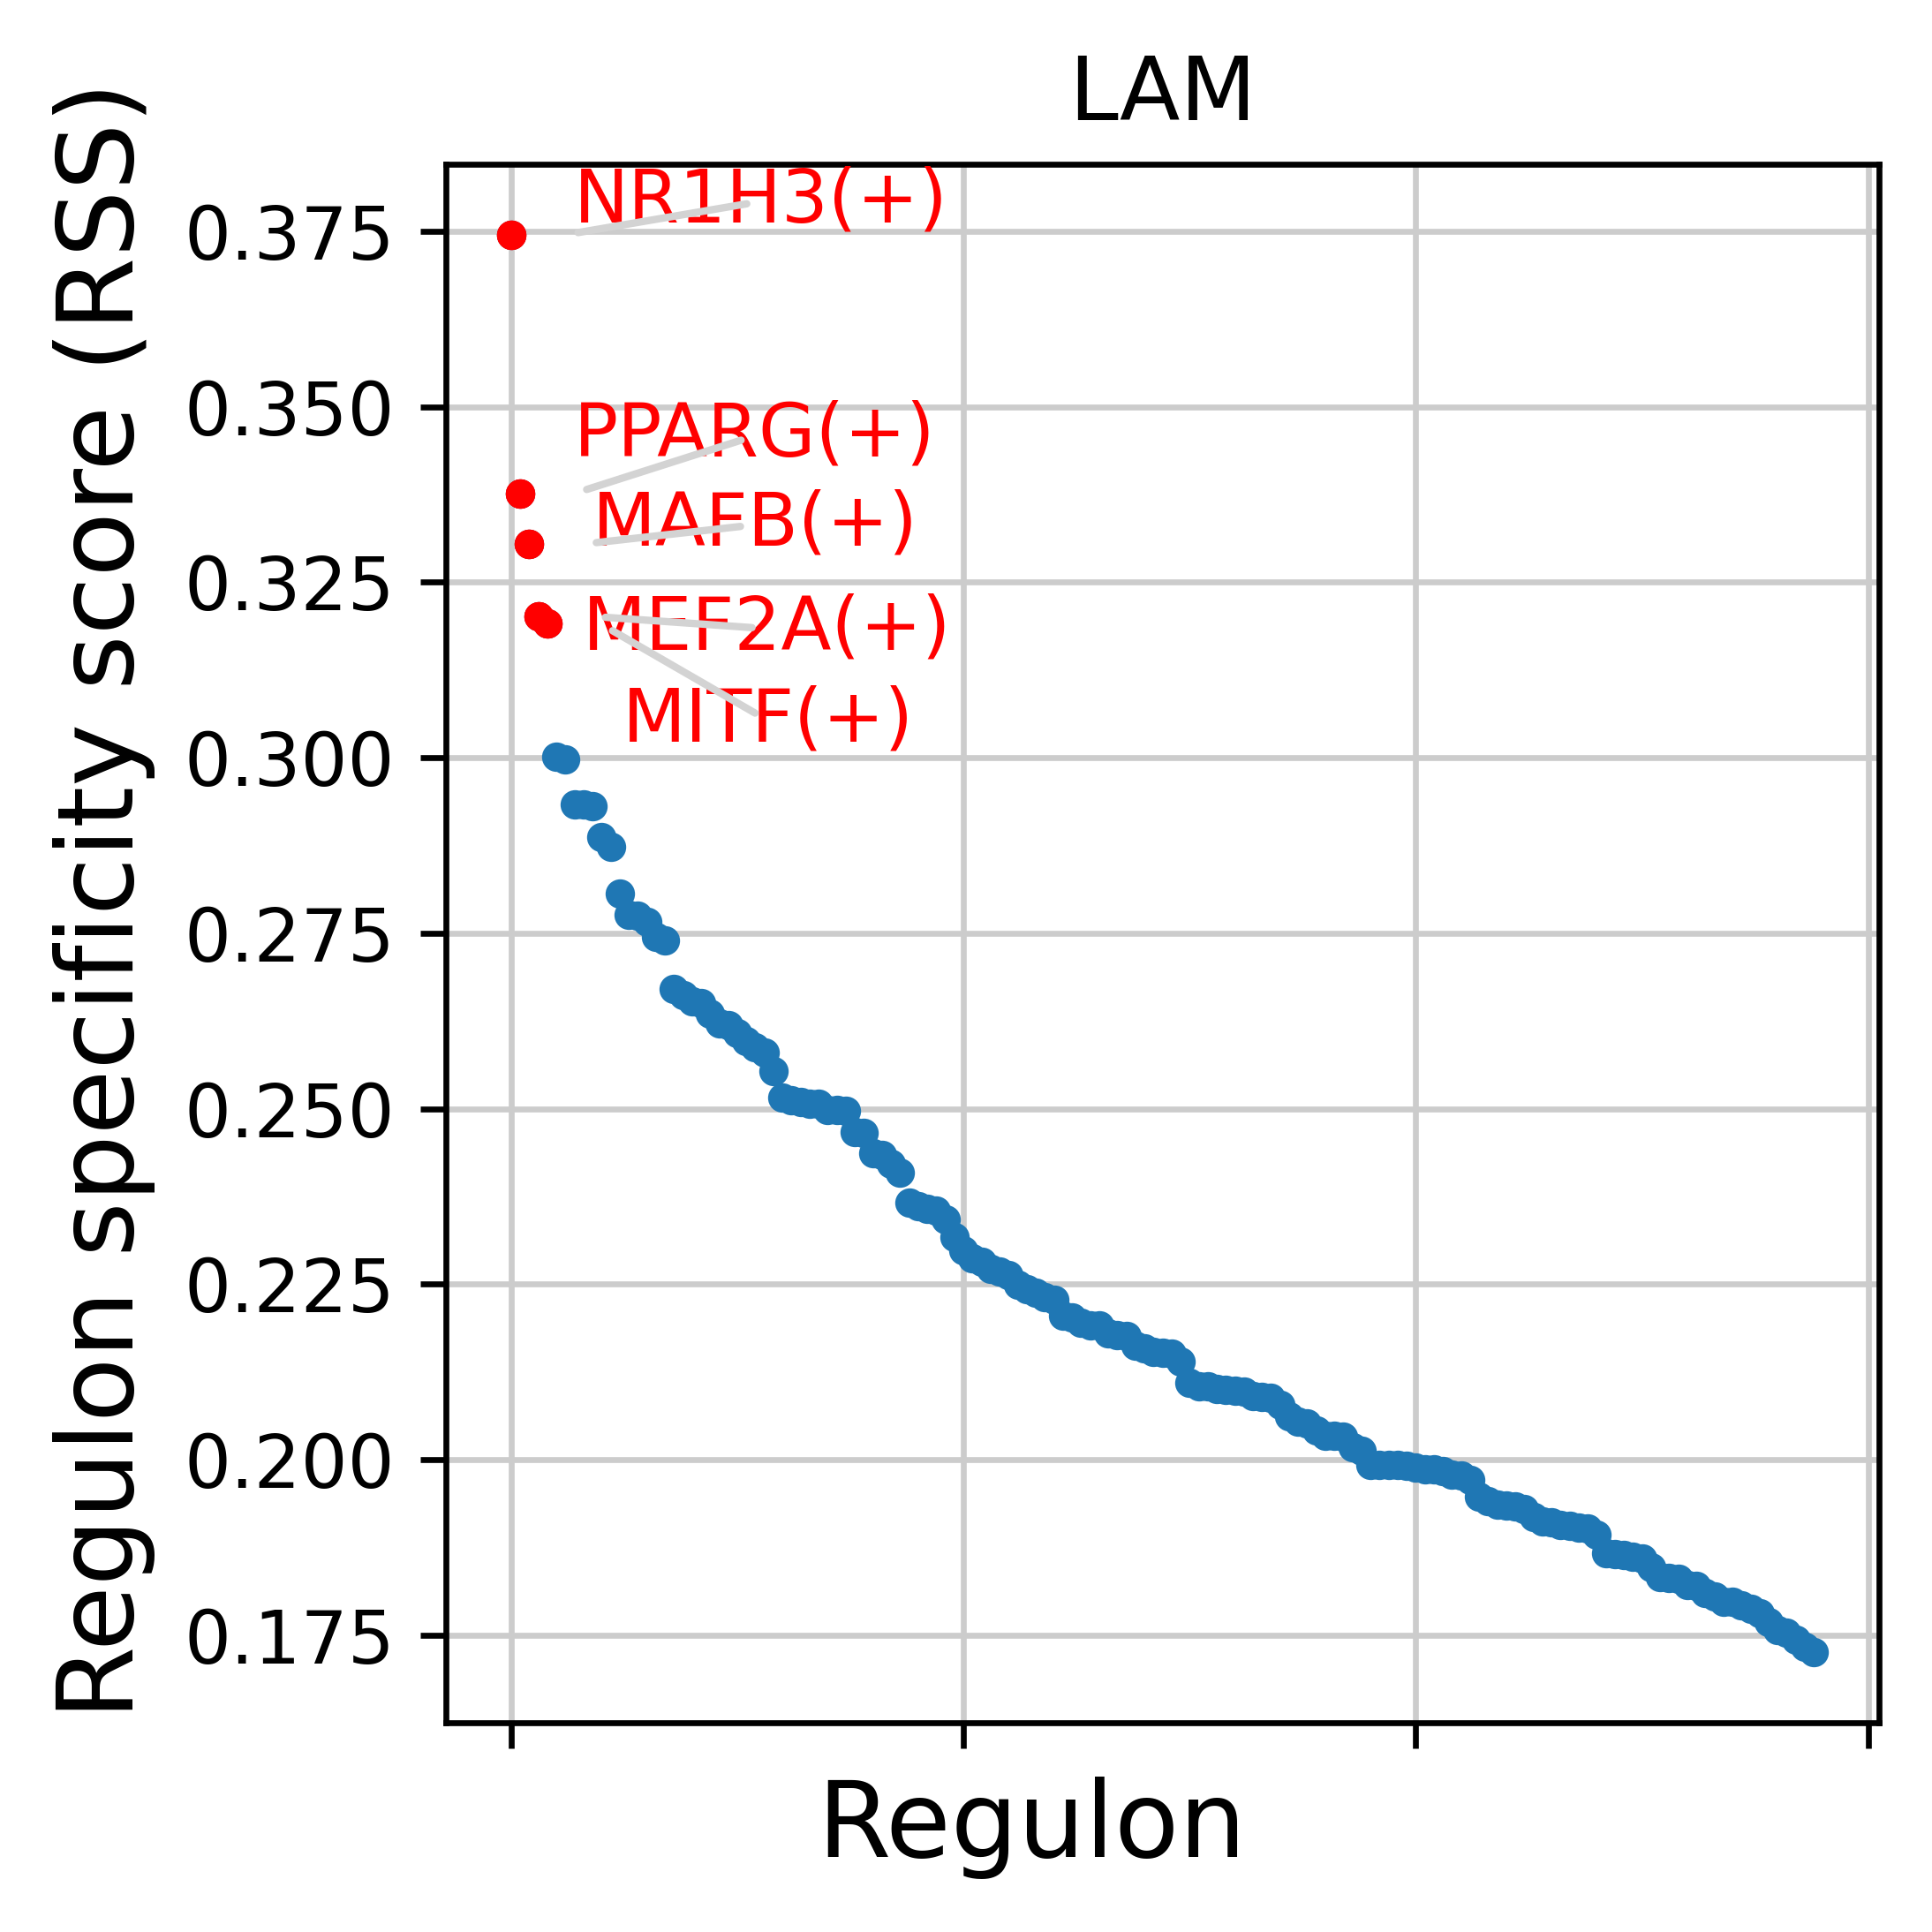

In [62]:
cats = ['LAM']
fig = plt.figure(figsize=(3.5, 3.5))
for c,num in zip(cats,range(1,len(cats)+1)):
    x = rss_celltype.T[c]
    ax = fig.add_subplot(1,1,num)
    plot_rss(rss_celltype, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min()-(x.max()-x.min())*0.05,x.max()+(x.max()-x.min())*0.05)
    for t in ax.texts:
        t.set_fontsize(10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts,autoalign='xy',ha='right',va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'),precision=0.001)
fig.text(0.5,0.0,'Regulon',ha='center',va='center',size='x-large')
fig.text(0.00,0.5,'Regulon specificity score (RSS)',ha='center',va='center',size='x-large',rotation='vertical')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout':True,
    'figure.titlesize':'large',
    'axes.labelsize':'medium',
    'axes.titlesize':'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize':'medium'
})
#plt.savefig(os.path.join(RESULTS_FOLDERNAME, 'LAMs-RSS-top5.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [94]:
#select the top 5 regulons from each cell type
topreg = []
for i,c in enumerate(cats):
    topreg.extend(rss_celltype.T[c].sort_values(ascending=False)[:5].index)
topreg = list(set(topreg))

In [107]:
# Generate a Z-score for each regulon to enable comparison between regulons
auc_mtx_Z = pd.DataFrame(index=auc_mtx.index)
for col in list(auc_mtx.columns):
    auc_mtx_Z[col] = (auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

/tmp/ipykernel_3839376/3452733496.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[col] = (auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_3839376/3452733496.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[col] = (auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_3839376/3452733496.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [ ]:
# Generate a heatmap
def palplot(pal,names,colors=None,size=1):
    n = len(pal)
    f, ax = plt.subplots(1,1,figsize = (n*size,size))
    ax.imshow(np.arange(n).reshape(1,n),cmap=mpl.colors.ListedColormap(list(pal)),interpolation='nearest',aspect='auto')
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [ ]:
cell_type_lvl2_palette={
    "Tnaive": "lightgrey",
    'MAIT': '#F4C4F4',
    "Teff": "#C98EE8",
    'Treg' : '#EE3A8C',
    "Circulating NK cell": "Pink",
    'Circulating NKT cell': 'Hotpink',
    "Resident NK cell": "Purple",
    "Bnaive": "#7cb6de",
    'Bmemory': '#DDEFFF',
    "Plasma_IgG": "#F4C4F4",
    'Plasma_IgA' : '#4E79A7',
    'CD14+ Monocyte':'#d2af55ff',
    'CD16+ Monocyte':'#fff69eff',
    'KC':'#a23a26',
    'LAM':"#f4b5a0",
    'cDC1':'#4e79a7ff',
    'cDC2':'#f9db85ff',
    'pDC':'#a0cbe8ff',
    "Neutrophil": "#DAC3C3",
    "Cholangiocyte": "darkgreen",
    "LSEC": "#BAB0AC",
    "Portal Vein EC": "#ff7f0e",
    "Central Vein EC": "#E2E8A7",
    "Hepatocyte": "#A36F56",
    "HSC": "#9467bd",
    "Mast cell": "#8c564b"
    
}
sc.pl.umap(adata, color=['cell_type_lvl2'], legend_loc='on data', frameon=False, legend_fontsize=5, palette=cell_type_lvl2_palette, save='_cell_type_lvl2.pdf', title='')

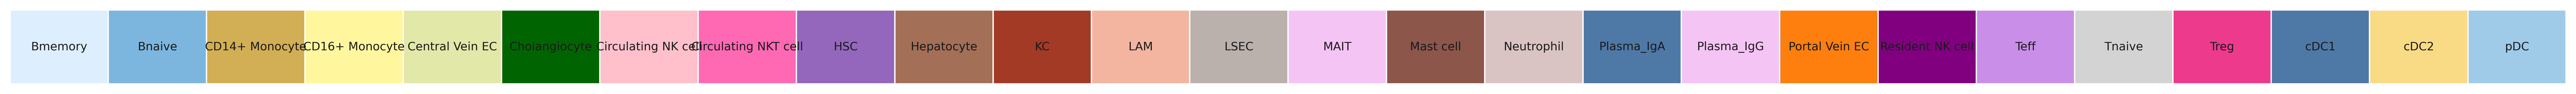

In [160]:
cats = sorted(list(set(adata.obs.cell_type_lvl2)))
colorsd = cell_type_lvl2_palette
colormap = [colorsd[x] for x in adata.obs.cell_type_lvl2]
color_map = adata.uns['cell_type_lvl2_colors']
sns.set()
sns.set(font_scale=0.7)
fig = palplot(pal=color_map, 
              names=adata.obs.cell_type_lvl2.dtype.categories, 
              colors=None, 
              size=1.0)
plt.savefig(os.path.join(RESULTS_FOLDERNAME, 'Pyscenic_celltype-heatmap-legend-top5.pdf'), dpi=300, bbox_inches='tight')

Create heatmap with binarized regulon activity

In [28]:
bin_mtx, thresholds = binarize(auc_mtx, num_workers=50)

In [114]:
THR_FNAME = os.path.join(RESULTS_FOLDERNAME,'thresholds.csv')
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

In [115]:
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME,'bin_mtx.csv')
bin_mtx.to_csv(BIN_MTX_FNAME)

In [116]:
bin_mtx = pd.read_csv(BIN_MTX_FNAME,index_col=0)
thresholds = pd.read_csv(THR_FNAME,index_col=0).threshold

In [ ]:
adata.obs['MITF(+)_binary'] = np.where(adata.obs['Regulon(MITF(+))'] > thresholds['MITF(+)'], 'positive', 'negative')
sc.set_figure_params(dpi=300, fontsize=10, dpi_save=300, figsize=(4.5, 4))
sc.pl.umap(adata, color=['MITF(+)_binary'], palette=['lightgrey', 'darkgreen'], save='MITF(+)_binary.pdf', s=2.5, title='Regulon(MITF(+))')

In [ ]:
adata.obs['PPARG(+)_binary'] = np.where(adata.obs['Regulon(PPARG(+))'] > thresholds['PPARG(+)'], 'positive', 'negative')
sc.set_figure_params(dpi=300, fontsize=10, dpi_save=300, figsize=(4.5, 4))
sc.pl.umap(adata, color=['PPARG(+)_binary'], palette=['lightgrey', 'darkred'], save='PPARG(+)_binary.pdf', s=2, title='Regulon(PPARG(+))')


In [ ]:
plot_binarization(auc_mtx, 'MITF(+)', thresholds['MITF(+)'])
plt.ylabel('')
plt.savefig(os.path.join(RESULTS_FOLDERNAME, 'MITF(+)_binarization.pdf'), dpi=300, bbox_inches='tight')
plot_binarization(auc_mtx, 'PPARG(+)', thresholds['PPARG(+)'])
plt.ylabel('')
plt.savefig(os.path.join(RESULTS_FOLDERNAME, 'PPARG(+)_binarization.pdf'), dpi=300, bbox_inches='tight')

In [ ]:
r = ['MITF(+)', 'PPARG(+)']
fig, axs = plt.subplots(1,len(r),figsize=(len(r)*4,4), dpi=300,sharey=False)
for i,ax in enumerate(axs):
    plot_binarization(auc_mtx,r[i],thresholds[r[i]],ax=ax)
fig.tight_layout()
#savesvg(os.path.join(RESULTS_FOLDERNAME, 'MITF&PPARG-activity-binarization.svg'), fig)

In [121]:
bw_palette = sns.xkcd_palette(['white', 'black'])

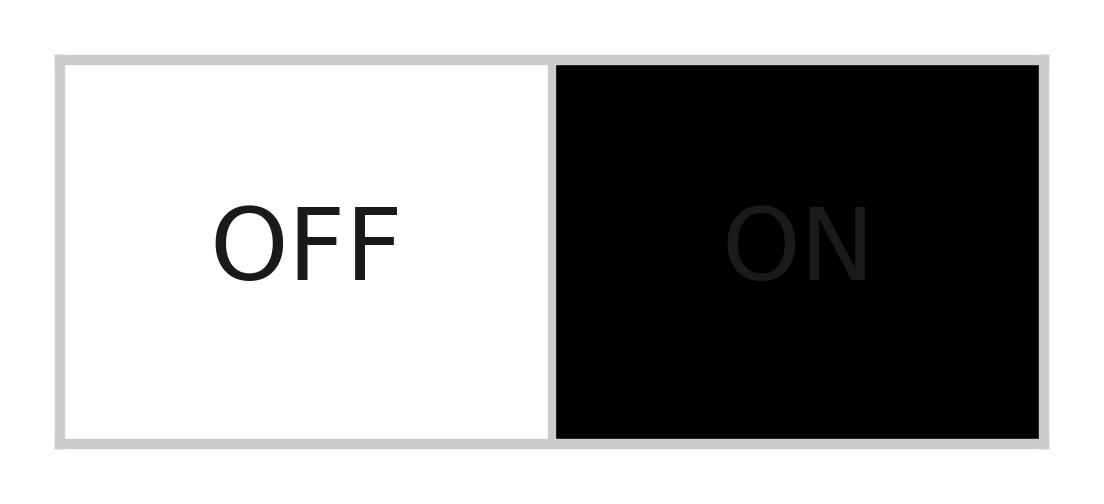

In [122]:
sns.set()
sns.set_style('whitegrid')
fig = palplot(bw_palette,['OFF','ON',['k','w']])
plt.savefig(os.path.join(RESULTS_FOLDERNAME, 'legend-on_off.pdf'))

In [171]:
g.fig.savefig(os.path.join(RESULTS_FOLDERNAME, 'Pyscenic_celltype-binary-heatmap-top5.png'), format='png', dpi=500, bbox_inches='tight')

In [ ]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style('ticks',{'xtick.minor.size':1, 'ytick.minor.size':0.1})
g = sns.clustermap(bin_mtx.T, figsize=(30, 55), cmap=bw_palette, col_colors=colormap)
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.cax.set_visible(False)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontdict={'fontsize':20, 'weight':'bold'})
g.ax_heatmap.set_ylabel('Regulons', fontdict={'fontsize':20,'weight':'bold'})
g.ax_heatmap.set_xlabel('Cells', fontdict={'fontsize':20,'weight':'bold'})
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'], fontdict={'fontsize':20,'weight':'bold'})
g.fig.savefig(os.path.join(RESULTS_FOLDERNAME, 'Pyscenic_celltype-binary-heatmap-top5.png'), format='png', dpi=500, bbox_inches='tight')

In [222]:
MITF_targets = adjacencies.loc[adjacencies.TF == 'MITF',:].sort_values('importance', ascending=False).reset_index(drop=True)
MITF_targets.to_csv(os.path.join(RESULTS_FOLDERNAME, 'MITF_targets.csv'), index=False)

In [ ]:
genes_dict = {
    'MITF_regulon': adjacencies.loc[adjacencies.TF == 'MITF',:].sort_values('importance',ascending=False).target[0:50],
}

In [ ]:
sc.pl.stacked_violin(adata, genes_dict, 'cell_type_lvl2', dendrogram=True, swap_axes=False, cmap='Blues', save='Regulon(MITF).pdf', var_group_rotation=0, title='')
#sc.pl.dotplot(adata, genes_dict, 'cell_type_lvl2', dendrogram=True, swap_axes=True, cmap='Blues', save='Regulon(MITF).pdf')